##### Copyright 2018 The TensorFlow Authors.



In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook is a modified version of from https://www.tensorflow.org/beta/tutorials/text/image_captioning

Given an image like the example below, our goal is to generate a caption such as "رجل يركب الأمواج".

![Man Surfing](https://tensorflow.org/images/surf.jpg)





In [0]:
!pip install tensorflow-gpu==2.0.0-beta0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

## Load the Arabic Annotation

Note that the captions were done automatically using Google translate so they are not accurate 

In [0]:
!wget https://raw.githubusercontent.com/zaidalyafeai/ARBML/master/datasets/Image%20Captioning/img_name_vector.txt
!wget https://raw.githubusercontent.com/zaidalyafeai/ARBML/master/datasets/Image%20Captioning/train_captions_ar.txt

In [0]:
with open('train_captions_ar.txt' , 'r') as f:
  train_captions_ar = f.readlines()
  
with open('img_name_vector.txt' , 'r') as f:
  img_name_vector = f.readlines()

In [0]:
train_captions_ar = ['<start> '+ cap.replace('\n','') + ' <end>' for cap in train_captions_ar]
img_name_vector = [img_name.replace('\n','') for img_name in img_name_vector]

<start> ثلاثة كلاب في الماء بالقرب من قارب مع منقذ للحياة. <end>


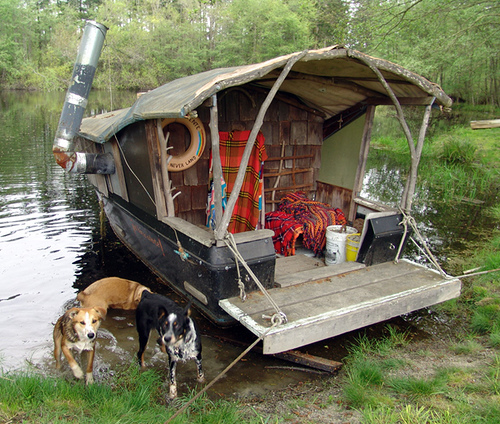

In [16]:
id = np.random.choice(range(len(train_captions_ar)))
print(train_captions_ar[id])

from IPython.display import Image
Image(img_name_vector[id])

## Preprocess the images using MobileNetV2
Next, you will use MobileNetV2 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into MobileNetV2's expected format by:
* Resizing the image to 224px by 224px


In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

## Initialize MobileNet and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the MobileNetV2 architecture. The shape of the output of this layer is ```7x7x1280```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.




In [0]:
image_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                weights='imagenet', input_shape = (224, 224, 3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from MoibleNetV2

You will pre-process each image with MobileNetV2 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 7\* 7 \* 1280 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.


In [0]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "كرة", "زرافة", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to the be same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,،-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions_ar)
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)

#add a word for padding 
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)



## Split the data into training and testing

In [23]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
features_shape = 1280
attention_features_shape = 49
units = 256
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

def create_dataset(img_name, cap):
  dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return dataset 

In [0]:
train_dataset = create_dataset(img_name_train, cap_train)
valid_dataset = create_dataset(img_name_val, cap_val)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (7, 7, 1280).
* You squash that to a shape of (49, 1280).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [0]:
def get_encoder(embedding_dim):
    input = tf.keras.layers.Input((attention_features_shape, features_shape))
    # shape after fc == (batch_size, 49, embedding_dim)
    output = tf.keras.layers.Dense(embedding_dim, activation = "relu")(input)
    
    return tf.keras.models.Model(inputs = input, outputs = output)
  
  
def get_decoder(embedding_dim, units, vocab_size):
    gru = tf.keras.layers.GRU(units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')

  
    #define the inputs to the decoder
    enc_output = tf.keras.layers.Input((attention_features_shape, embedding_dim))
    enc_hidden = tf.keras.layers.Input((embedding_dim,))
    dec_input = tf.keras.layers.Input((1,))
    
    hidden_with_time_axis = tf.keras.layers.Reshape((1, units))(enc_hidden)

    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
    W1 = tf.keras.layers.Dense(units)
    W2 = tf.keras.layers.Dense(units)
    V  = tf.keras.layers.Dense(1)
    
    attention_weights = V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([W1(enc_output), W2(hidden_with_time_axis)])))
    attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(attention_weights))
    attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.keras.layers.Multiply()([attention_weights, enc_output])
    
    # reshape the context_vector to concatneate with the output of the first input
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    context_vector = tf.keras.layers.Dense(1)(context_vector)
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(dec_input)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.keras.layers.Concatenate(axis = -1)([context_vector, x])
    # passing the concatenated vector to the GRU
    output, state = gru(x)
    
    output = tf.keras.layers.Dense(units)(output)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.keras.layers.Reshape((output.shape[2],))(output)

    # output shape == (batch_size * 1, vocab)
    x = tf.keras.layers.Dense(vocab_size)(output)

    return tf.keras.models.Model(inputs = [dec_input, enc_hidden, enc_output], outputs = [x, state])

In [0]:
encoder = get_encoder(embedding_dim)
decoder = get_decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Prediction

Let us see the output of the untrained model

In [0]:
def evaluate(image):

    hidden = tf.zeros((1, units))
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder([dec_input, hidden, features])

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result
  
def predict():
  # captions on the validation set
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result = evaluate(image)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))

  return Image(img_name_val[rid])

In [0]:
predict()

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  #hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden = tf.zeros((target.shape[0], units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder([dec_input, hidden, features])

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

@tf.function
def valid_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  #hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden = tf.zeros((target.shape[0], units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder([dec_input, hidden, features])

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [35]:
EPOCHS = 10

for epoch in range(0, EPOCHS):
    start = time.time()
    train_total_loss = 0
    valid_total_loss = 0 
    
    train_num_steps = 0 
    valid_num_steps = 0 

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        train_total_loss += t_loss
        train_num_steps += 1

    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        _, t_loss = valid_step(img_tensor, target)
        valid_total_loss += t_loss
        valid_num_steps += 1
        
    print ('Epoch {} train_Loss {:.2f} valid_Loss {:.2f}'.format(epoch + 1, train_total_loss/train_num_steps,
                                         valid_total_loss/valid_num_steps))
    predict()
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 train_Loss 1.37 valid_Loss 1.20
Real Caption: <start> شخص ذو مظلة ملونة متعددة يقف بالقرب من سفينة سياحية <end>
Prediction Caption: رجل يرتدي قميصًا يجلس على طاولة <end>
Time taken for 1 epoch 318.50827836990356 sec

Epoch 2 train_Loss 1.13 valid_Loss 1.09
Real Caption: <start> ثلاث صور لشخص يحمل جهاز تحكم عن بعد ويبدو أن كومة من الصناديق تتحقق <end>
Prediction Caption: رجل يرتدي سترة سوداء <end>
Time taken for 1 epoch 203.56551694869995 sec

Epoch 3 train_Loss 1.03 valid_Loss 1.01
Real Caption: <start> مجموعة من كبار السن يجلسون حول وجبة طعام معًا <end>
Prediction Caption: رجل يرتدي نظارة <unk> <unk> <unk> <end>
Time taken for 1 epoch 204.68605852127075 sec

Epoch 4 train_Loss 0.94 valid_Loss 0.97
Real Caption: <start> شخص يرتدي جميع الأسود يطير طائرة ورقية <end>
Prediction Caption: طائرة ركاب كبيرة من الناس على الشاطئ <end>
Time taken for 1 epoch 206.4133906364441 sec

Epoch 5 train_Loss 0.88 valid_Loss 0.95
Real Caption: <start> عربة إطفاء تتحرك على طول الطريق خلال النهار <e

Real Caption: <start> مرحاض أبيض يجلس بجانب حوض أبيض <end>
Prediction Caption: حمام مع مرحاض أبيض في الحمام <end>


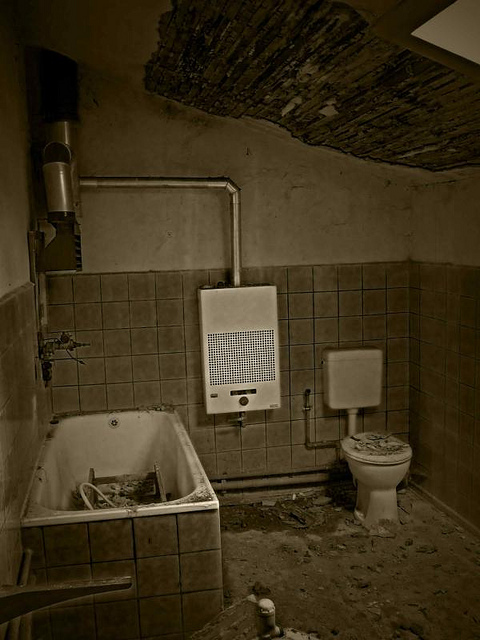

In [58]:
predict()

## Save the models and Dictionary

In [0]:
#attach the feature extraction model with the encoder
input = tf.keras.layers.Input((224, 224, 3))
x = image_model(input)
x = tf.keras.layers.Reshape((49, 1280))(x)
x = encoder(x)
attached = tf.keras.models.Model(inputs = input, outputs = x)

#save the encoder decoder
attached.save('encoder.h5')
decoder.save('decoder.h5')

In [0]:
#save the dictionary
import csv
def create_csv(file, dict):
    with open(file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for key in dict.keys():
            writer.writerow([key,dict[key]])
create_csv('idx2word.csv', tokenizer.index_word)